<a href="https://colab.research.google.com/github/kingao12/stock-price-prediction/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas_datareader import data as pdr
import yfinance as yf

In [ ]:
yf.pdr_override()

now = datetime.now()
before = now - relativedelta(years=26)

now_day = now.strftime("%Y-%m-%d")
before_day = before.strftime("%Y-%m-%d")
print(f'end:{now_day}')
print(f'start:{before_day}')

samsung_stock = pdr.get_data_yahoo("005930.KS", start=before_day, end=now_day)
print(samsung_stock)

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.
end:2024-06-10
start:1998-06-10


[*********************100%%**********************]  1 of 1 completed

               Open     High      Low    Close     Adj Close    Volume
Date                                                                  
2000-01-04   6000.0   6110.0   5660.0   6110.0   4449.711426  74195000
2000-01-05   5800.0   6060.0   5520.0   5580.0   4063.729980  74680000
2000-01-06   5750.0   5780.0   5580.0   5620.0   4092.859131  54390000
2000-01-07   5560.0   5670.0   5360.0   5540.0   4034.600342  40305000
2000-01-10   5600.0   5770.0   5580.0   5770.0   4202.099609  46880000
...             ...      ...      ...      ...           ...       ...
2024-05-31  74500.0  74700.0  73500.0  73500.0  73500.000000  26198776
2024-06-03  74400.0  76400.0  74200.0  75700.0  75700.000000  15706268
2024-06-04  74900.0  76100.0  74900.0  75300.0  75300.000000  14098053
2024-06-05  78000.0  78000.0  76800.0  77400.0  77400.000000  23177968
2024-06-07  78400.0  78600.0  77100.0  77300.0  77300.000000  21189349

[6123 rows x 6 columns]


In [ ]:
close_prices = samsung_stock['Close'].values
print(close_prices)

windown_size = 30

result_list = []
for i in range(len(close_prices) - (windown_size + 1)):
    result_list.append(close_prices[i: i+(windown_size+1)])

normal_data = []
for window in result_list:
    window_list = [((float(p) / float(window[0])) - 1) for p in window]
    normal_data.append(window_list)

result_list = np.array(normal_data)
print(result_list.shape[0], result_list.shape[1])

[ 6110.  5580.  5620. ... 75300. 77400. 77300.]
6092 31


In [ ]:
row = int(round(result_list.shape[0] * 0.9))
train = result_list[:row, :]

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result_list[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result_list[row:, -1]

x_train.shape, x_test.shape

((5483, 30, 1), (609, 30, 1))

In [ ]:
model = Sequential()
model.add(LSTM(windown_size, return_sequences=True, input_shape=(windown_size, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation = 'linear'))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 30)            3840      
                                                                 
 lstm_1 (LSTM)               (None, 64)                24320     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 28225 (110.25 KB)
Trainable params: 28225 (110.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=20,
          epochs=20)

model.save(r'\39_predict\samsung.h5')

Epoch 1/20
275/275 [==============================] - 10s 10ms/step - loss: 0.0021 - val_loss: 5.2319e-04
Epoch 2/20
275/275 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 4.2955e-04
Epoch 3/20
275/275 [==============================] - 2s 9ms/step - loss: 0.0012 - val_loss: 4.4190e-04
Epoch 4/20
275/275 [==============================] - 2s 7ms/step - loss: 0.0010 - val_loss: 5.4820e-04
Epoch 5/20
275/275 [==============================] - 2s 7ms/step - loss: 9.5862e-04 - val_loss: 8.0846e-04
Epoch 6/20
275/275 [==============================] - 2s 7ms/step - loss: 9.1079e-04 - val_loss: 3.0203e-04
Epoch 7/20
275/275 [==============================] - 2s 7ms/step - loss: 8.4709e-04 - val_loss: 7.4286e-04
Epoch 8/20
275/275 [==============================] - 2s 7ms/step - loss: 8.2070e-04 - val_loss: 3.0425e-04
Epoch 9/20
275/275 [==============================] - 3s 9ms/step - loss: 7.8387e-04 - val_loss: 3.6552e-04
Epoch 10/20
275/275 [=====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 1s 4ms/step


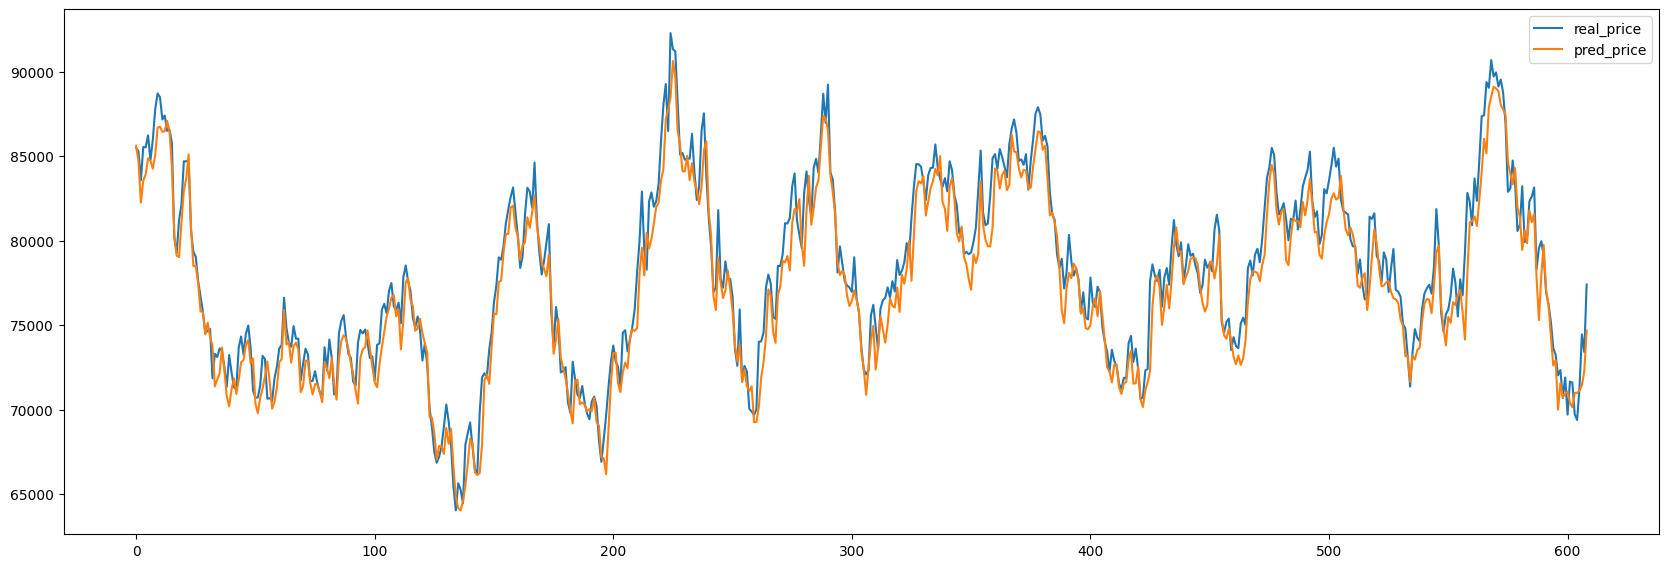

In [ ]:
pred = model.predict(x_test)

pred_price = []
for i in pred:
    pred_price.append((i+1)*window[0])

real_price = []
for i in y_test:
    real_price.append((i+1)*window[0])

fig = plt.figure(facecolor='white', figsize=(70, 15))
ax = fig.add_subplot(234)
ax.plot(real_price, label='real_price')
ax.plot(pred_price, label='pred_price')
ax.legend()
plt.show()